In [1]:
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
import seaborn as sns
sns.set_theme(color_codes=True)
from scipy import stats
import statsmodels.api as sm
import numpy as np
import json

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Read the Data

In [2]:
first_session_raw_data = pd.read_csv('Data/first_round_data.csv', index_col=0).reset_index().drop(columns=['index'])
# first_session_raw_data = first_session_raw_data[first_session_raw_data.mturkID != 'nan' ]

num_all_experimenters = len(first_session_raw_data.mturkID.unique())
num_excluded_experimenters = 0

first_session_raw_data.head()

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,run_id,condition,rt,url,trial_type,trial_index,time_elapsed,internal_node_id,experiment_id,assignmentID,mturkID,hitID,exp_final_status,success,timeout,failed_images,failed_audio,failed_video,stimulus,response,exp_stage,view_history,exp_part,question_order,quiz_score,recorded_at,ip,user_agent,device,browser,browser_version,platform,platform_version,source_code_version,focus_screen,color,cond,cond_action,cond_outcome,block,side,x_circle,y_circle,choice,correct,curr_bonus,trial_bonus,outcome,feedback_points,prob_fall,expected_feedback,agg_fb_pts,error_block,num_gos,num_nogos,suspicious,hitId,workerId,assignmentId,a,tp_a,b,tp_b,c,tp_c,suspicious_type
0,115,1,7069,https://raw.githubusercontent.com/Sepsad/Ortho...,external-html,0,7223,0.0-0.0,GNG_jaokgw1e,35LDD5557B73ZRZ59T8367CD4KEMKS,A1AMGHYG5PT0L2,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,not_completed_by_failing_quiz,"""","""","""","""","""","""","""","""","""","""","""","""",2021-11-23 16:41:37,137.148.113.99,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WebKit,Chrome,96.0.4664.45,Windows,10.0,ff253546778cd407e57361676f185c6a,focus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,A1AMGHYG5PT0L2,35LDD5557B73ZRZ59T8367CD4KEMKS,5DL57,5DL57,35LDD5557B73ZRZ59T8367CD4KEMKS,35LDD5557B73ZRZ59T8367CD4KEMKS,332327.0,332327.0,NaN
1,115,1,10702.699999809265,https://raw.githubusercontent.com/Sepsad/Ortho...,external-html,1,18151,0.0-1.0,GNG_jaokgw1e,35LDD5557B73ZRZ59T8367CD4KEMKS,A1AMGHYG5PT0L2,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,not_completed_by_failing_quiz,"""","""","""","""","""","""","""","""","""","""","""","""",2021-11-23 16:41:37,137.148.113.99,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WebKit,Chrome,96.0.4664.45,Windows,10.0,ff253546778cd407e57361676f185c6a,"""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,A1AMGHYG5PT0L2,35LDD5557B73ZRZ59T8367CD4KEMKS,5DL57,5DL57,35LDD5557B73ZRZ59T8367CD4KEMKS,35LDD5557B73ZRZ59T8367CD4KEMKS,332327.0,332327.0,NaN
2,115,1,"""","""",preload,2,19590,0.0-2.0,GNG_jaokgw1e,35LDD5557B73ZRZ59T8367CD4KEMKS,A1AMGHYG5PT0L2,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,not_completed_by_failing_quiz,true,false,[],[],[],"""","""","""","""","""","""","""",2021-11-23 16:41:37,137.148.113.99,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WebKit,Chrome,96.0.4664.45,Windows,10.0,ff253546778cd407e57361676f185c6a,"""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,A1AMGHYG5PT0L2,35LDD5557B73ZRZ59T8367CD4KEMKS,5DL57,5DL57,35LDD5557B73ZRZ59T8367CD4KEMKS,35LDD5557B73ZRZ59T8367CD4KEMKS,332327.0,332327.0,NaN
3,115,1,2415.5999999046326,"""",html-button-response,3,22007,0.0-3.0,GNG_jaokgw1e,35LDD5557B73ZRZ59T8367CD4KEMKS,A1AMGHYG5PT0L2,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,not_completed_by_failing_quiz,"""","""","""","""","""",<img src='../img/welcome.gif' style='height: 2...,0,first_welcome,"""","""","""","""",2021-11-23 16:41:37,137.148.113.99,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WebKit,Chrome,96.0.4664.45,Windows,10.0,ff253546778cd407e57361676f185c6a,"""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,A1AMGHYG5PT0L2,35LDD5557B73ZRZ59T8367CD4KEMKS,5DL57,5DL57,35LDD5557B73ZRZ59T8367CD4KEMKS,35LDD5557B73ZRZ59T8367CD4KEMKS,332327.0,332327.0,NaN
4,115,1,8928.599999904633,"""",instructions,4,30936,0.0-4.0,GNG_jaokgw1e,35LDD5557B73ZRZ59T8367CD4KEMKS,A1AMGHYG5PT0L2,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,not_completed_by_failing_quiz,"""","""","""","""","""","""","""",before_instructions,"[{""page_index"":0,""viewing_time"":1983.5},{""page...",before_instructions,"""","""",2021-11-23 16:41:37,137.148.113.99,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WebKit,Chrome,96.0.4664.45,Windows,10.0,ff253546778cd407e57361676f185c6a,"""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3WPCIUYH

# Apply exclusion criteria

1. Fail the quiz of instructions more than twice.
2. Change the tab or window of the experiment.

In [3]:
first_session_clean_data = first_session_raw_data[(first_session_raw_data.exp_final_status == 'fully_completed')]

num_excluded_experimenters = len(first_session_raw_data.mturkID.unique()) - len(first_session_clean_data.mturkID.unique())

print("Number of participants excluded by this criterias:", num_excluded_experimenters)

Number of participants excluded by this criterias: 8


3. Respond randomly, always go or never go.

    * Note: We exclude who repond randomly, always go or nogo in each 3 block

In [4]:
first_session_clean_data[first_session_clean_data.suspicious == 'true'][['mturkID', 'suspicious_type','num_gos', 'block']]

,mturkID,suspicious_type,num_gos,block
2201,A1FVXS8IM5QYO8,error_rate,33,block_2
13298,A1Y8BGDLPNYP0K,time_outs,0,block_1
13539,A1Y8BGDLPNYP0K,time_outs,0,block_2
13780,A1Y8BGDLPNYP0K,time_outs,0,block_3
16204,AQMLJYUQCSG22,error_rate,36,block_3
20007,A2G7F8S617H0BB,all_one,40,block_2
25096,A1SMVF4MXT0RIH,error_rate,38,block_3
31892,A68J20100VW4W,error_rate,39,block_1
39476,A27O7H19C0WQ7T,time_outs,0,block_1
39717,A27O7H19C0WQ7T,time_outs,0,block_2


In [5]:
IDs_for_exclusion_by_random_response = ['A1Y8BGDLPNYP0K', 'A27O7H19C0WQ7T']

num_excluded_experimenters += len(IDs_for_exclusion_by_random_response)

first_session_clean_data = first_session_clean_data[first_session_clean_data.isin(IDs_for_exclusion_by_random_response) == False]

print("Number of participants excluded by this criterias:", len(IDs_for_exclusion_by_random_response))


Number of participants excluded by this criterias: 2


4. Their rate of the correct response to detection of circle side task is less than 55%.

In [6]:
circle_side_correctness = first_session_clean_data[first_session_clean_data.choice == 'go'][['mturkID','side', 'response']]
circle_side_correctness['is_correct_circle_side'] =  (circle_side_correctness.side == circle_side_correctness.response)
accuracy_data = circle_side_correctness.groupby('mturkID').mean().reset_index()
accuracy_data.columns = ['mturkID', 'rate']
accuracy_data['is_below_55'] = accuracy_data.rate < 0.55

accuracy_data.head()


,mturkID,rate,is_below_55
0,A12FTSX85NQ8N9,0.895833,False
1,A1BNGJBEWJS8WE,0.544444,True
2,A1CY7IOJ9YH136,1.000000,False
3,A1DZMZTXWOM9MR,1.000000,False
4,A1FVXS8IM5QYO8,0.788991,False


In [7]:
non_accurate_IDs = accuracy_data[accuracy_data.is_below_55].mturkID

num_excluded_experimenters += len(non_accurate_IDs)

first_session_clean_data = first_session_clean_data[first_session_clean_data.isin(list(non_accurate_IDs)) == False]
print("Number of participants excluded by this criterias:", len(non_accurate_IDs))



Number of participants excluded by this criterias: 13


# Plot Perforance per conditions

/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_72647/1135958102.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)


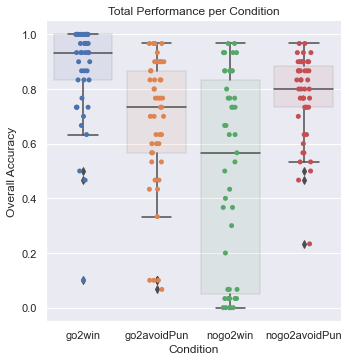

In [8]:
mapping = {'1': 'go2win', '2': 'nogo2win', '3': 'go2avoidPun', '4' : 'nogo2avoidPun'} 

circle_task_logs = first_session_clean_data[first_session_clean_data.exp_stage == 'main_target_detection']

circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)
performance_per_condition = circle_task_logs.groupby(['mturkID','cond']).mean().reset_index()
performance_per_condition.cond = performance_per_condition.cond.map(mapping)

ax = sns.catplot(x="cond", y="correct", data=performance_per_condition, order= ['go2win','go2avoidPun' ,'nogo2win', 'nogo2avoidPun']);
ax = sns.boxplot(x="cond", y="correct", data= performance_per_condition, boxprops=dict(alpha=.1), order= ['go2win','go2avoidPun' ,'nogo2win', 'nogo2avoidPun']);

ax.set(xlabel="Condition", ylabel = "Overall Accuracy", title = 'Total Performance per Condition')
plt.show()


In [9]:
len(performance_per_condition.mturkID.unique())

47

In [10]:
performance_per_condition.pivot(index='mturkID', columns='cond', values='correct').reset_index().to_csv('Data/first_round_performance_per_condition.csv')